In [1]:
from pathlib import Path
from shutil import copy2
import argparse
import cv2

# A..K (skip G) -> 10 classes
CLASSES = ['A','B','C','D','E','F','H','I','J','K']
CLASS2ID = {c:i for i,c in enumerate(CLASSES)}
IMG_EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}

def read_list_file(list_path: Path):
    """Read a file with one image basename per line (with or without extension)."""
    items = []
    for ln in list_path.read_text(encoding="utf-8", errors="ignore").splitlines():
        s = ln.strip()
        if not s:
            continue
        items.append(s)
    return items

def resolve_image_path(colour_dir: Path, stem_or_name: str):
    """Return Path to existing image (try common extensions)."""
    p = colour_dir / stem_or_name
    if p.exists():
        return p
    stem = Path(stem_or_name).stem
    for ext in IMG_EXTS:
        q = colour_dir / f"{stem}{ext}"
        if q.exists():
            return q
    return None

def read_boxes_ouhands(txt_path: Path):
    """
    Parse OUHands bbox txt:
      line1: N (number of boxes)
      next N lines: x w h y [score]
    Return list of (xmin, ymin, xmax, ymax) floats.
    """
    boxes = []
    if not txt_path.exists():
        return boxes
    lines = [ln.strip() for ln in txt_path.read_text(encoding="utf-8", errors="ignore").splitlines() if ln.strip()]
    if len(lines) <= 1:
        return boxes
    try:
        n = int(float(lines[0].split()[0]))
        rows = lines[1:1+n]
    except Exception:
        rows = lines
    for row in rows:
        parts = [p for p in row.replace("\t", " ").split() if p]
        if len(parts) < 4:
            continue
        x, w, h, y = map(float, parts[:4])
        xmin, ymin = x, w
        xmax, ymax = x + h, y + w
        # normalize order + minimal validity
        if xmax - xmin >= 1 and ymax - ymin >= 1:
            boxes.append((xmin, ymin, xmax, ymax))
    return boxes

def to_yolo_norm(xmin, ymin, xmax, ymax, W, H):
    xmin = max(0.0, min(xmin, W - 1.0))
    xmax = max(0.0, min(xmax, W - 1.0))
    ymin = max(0.0, min(ymin, H - 1.0))
    ymax = max(0.0, min(ymax, H - 1.0))
    bw = max(1.0, xmax - xmin)
    bh = max(1.0, ymax - ymin)
    cx = xmin + bw / 2.0
    cy = ymin + bh / 2.0
    return cx / W, cy / H, bw / W, bh / H

def im_wh(img_path: Path):
    im = cv2.imread(str(img_path))
    if im is None:
        return None, None
    h, w = im.shape[:2]
    return w, h

def convert_split(split_name: str, filelist_path: Path, colour_dir: Path, bbox_dir: Path, out_root: Path):
    out_img = out_root / split_name / "images"
    out_lbl = out_root / split_name / "labels"
    out_img.mkdir(parents=True, exist_ok=True)
    out_lbl.mkdir(parents=True, exist_ok=True)

    names = read_list_file(filelist_path)
    kept, empty = 0, 0

    for name in names:
        imgp = resolve_image_path(colour_dir, name)
        if imgp is None:
            # missing image
            continue

        cls_letter = imgp.name[0].upper()
        if cls_letter not in CLASS2ID:
            # skip unknown prefix
            continue
        cid = CLASS2ID[cls_letter]

        W, H = im_wh(imgp)
        if W is None:
            continue

        txtp = bbox_dir / (imgp.stem + ".txt")
        boxes = read_boxes_ouhands(txtp)

        # write YOLO label
        with open(out_lbl / f"{imgp.stem}.txt", "w", encoding="utf-8") as f:
            if not boxes:
                empty += 1
            else:
                for (x1, y1, x2, y2) in boxes:
                    cx, cy, w, h = to_yolo_norm(x1, y1, x2, y2, W, H)
                    f.write(f"{cid} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}\n")

        copy2(imgp, out_img / imgp.name)
        kept += 1

    return kept, empty

def write_yaml(out_root: Path, has_val: bool):
    yaml = out_root / "data.yaml"
    train_img = (out_root / "train" / "images").as_posix()
    val_img = (out_root / ("val" if has_val else "train") / "images").as_posix()
    with open(yaml, "w", encoding="utf-8") as f:
        f.write(
            f"# auto-generated OUHands for YOLOv8 detect (10 classes A..K skip G)\n"
            f"train: {train_img}\n"
            f"val: {val_img}\n"
            f"nc: {len(CLASSES)}\n"
            f"names: {CLASSES}\n"
        )
    print("✅ wrote", yaml.resolve())

In [2]:
train_list = Path(r"D:\Courses\Csc2503\proj\archive\OUHANDS_train\data_split_for_intermediate_tests\training_files.txt")
val_list   = Path(r"D:\Courses\Csc2503\proj\archive\OUHANDS_train\data_split_for_intermediate_tests\validation_files.txt")
colour_dir = Path(r"D:\Courses\Csc2503\proj\archive\OUHANDS_train\train\hand_data\colour")
bbox_dir   = Path(r"D:\Courses\Csc2503\proj\archive\OUHANDS_train\train\hand_data\bounding_box")
out_root   = Path(r"D:\Courses\Csc2503\proj\data_yolo_ouhands")
out_root.mkdir(parents=True, exist_ok=True)      
kept_tr, empty_tr = convert_split("train", train_list, colour_dir, bbox_dir, out_root)
kept_va, empty_va = convert_split("val",   val_list,   colour_dir, bbox_dir, out_root)

write_yaml(out_root, has_val=True)

print("\nSummary:")
print(f"  train: kept={kept_tr}, empty_labels={empty_tr}")
print(f"  val  : kept={kept_va}, empty_labels={empty_va}")
print("Output:", out_root.resolve())
print("  train/images:", (out_root/'train'/'images').resolve())
print("  train/labels:", (out_root/'train'/'labels').resolve())
print("  val/images  :", (out_root/'val'/'images').resolve())
print("  val/labels  :", (out_root/'val'/'labels').resolve())

✅ wrote D:\Courses\Csc2503\proj\data_yolo_ouhands\data.yaml

Summary:
  train: kept=1600, empty_labels=0
  val  : kept=400, empty_labels=0
Output: D:\Courses\Csc2503\proj\data_yolo_ouhands
  train/images: D:\Courses\Csc2503\proj\data_yolo_ouhands\train\images
  train/labels: D:\Courses\Csc2503\proj\data_yolo_ouhands\train\labels
  val/images  : D:\Courses\Csc2503\proj\data_yolo_ouhands\val\images
  val/labels  : D:\Courses\Csc2503\proj\data_yolo_ouhands\val\labels


Train

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
from pathlib import Path
from shutil import copy2
import cv2
from tqdm import tqdm
import random
from PIL import Image
from IPython.display import display
from ultralytics import YOLO


In [2]:
# 你的数据路径
ROOT = Path(r"D:\Courses\Csc2503\proj\archive\OUHANDS_train")

TRAIN_LIST = ROOT / r"data_split_for_intermediate_tests\training_files.txt"
VAL_LIST   = ROOT / r"data_split_for_intermediate_tests\validation_files.txt"

COLOUR_DIR = ROOT / r"train\hand_data\colour"
BBOX_DIR   = ROOT / r"train\hand_data\bounding_box"

# 输出数据集根目录（可改）
OUT_ROOT = Path(r"D:\Courses\Csc2503\proj\data_yolo_ouhands_nb")

# 类别（A~K，跳过G）
CLASSES = ['A','B','C','D','E','F','H','I','J','K']
CLASS2ID = {c:i for i,c in enumerate(CLASSES)}
IMG_EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}

print("Train list:", TRAIN_LIST)
print("Val   list:", VAL_LIST)
print("Images dir:", COLOUR_DIR)
print("Boxes  dir:", BBOX_DIR)


Train list: D:\Courses\Csc2503\proj\archive\OUHANDS_train\data_split_for_intermediate_tests\training_files.txt
Val   list: D:\Courses\Csc2503\proj\archive\OUHANDS_train\data_split_for_intermediate_tests\validation_files.txt
Images dir: D:\Courses\Csc2503\proj\archive\OUHANDS_train\train\hand_data\colour
Boxes  dir: D:\Courses\Csc2503\proj\archive\OUHANDS_train\train\hand_data\bounding_box


In [3]:
def read_list_file(list_path: Path):
    items = []
    for ln in list_path.read_text(encoding="utf-8", errors="ignore").splitlines():
        s = ln.strip()
        if not s:
            continue
        items.append(s)
    return items

def resolve_image_path(colour_dir: Path, stem_or_name: str):
    p = colour_dir / stem_or_name
    if p.exists():
        return p
    stem = Path(stem_or_name).stem
    for ext in IMG_EXTS:
        q = colour_dir / f"{stem}{ext}"
        if q.exists():
            return q
    return None

def read_boxes_ouhands(txt_path: Path):
    """
    解析 OUHands bbox:
      第1行: N
      后续 N 行: x, w, h, y, [score]
    转成 (xmin, ymin, xmax, ymax) 列表返回
    """
    boxes = []
    if not txt_path.exists():
        return boxes
    lines = [ln.strip() for ln in txt_path.read_text(encoding="utf-8", errors="ignore").splitlines() if ln.strip()]
    if len(lines) <= 1:
        return boxes
    try:
        n = int(float(lines[0].split()[0]))
        rows = lines[1:1+n]
    except Exception:
        rows = lines
    for row in rows:
        parts = [p for p in row.replace("\t"," ").split() if p]
        if len(parts) < 4:
            continue
        x, w, h, y = map(float, parts[:4])
        xmin, ymin = x, w
        xmax, ymax = x + h, y + w
        if xmax - xmin >= 1 and ymax - ymin >= 1:
            boxes.append((xmin, ymin, xmax, ymax))
    return boxes

def to_yolo_norm(xmin, ymin, xmax, ymax, W, H):
    xmin = max(0.0, min(xmin, W-1.0))
    xmax = max(0.0, min(xmax, W-1.0))
    ymin = max(0.0, min(ymin, H-1.0))
    ymax = max(0.0, min(ymax, H-1.0))
    bw = max(1.0, xmax - xmin)
    bh = max(1.0, ymax - ymin)
    cx = xmin + bw / 2.0
    cy = ymin + bh / 2.0
    return cx / W, cy / H, bw / W, bh / H

def im_wh(img_path: Path):
    im = cv2.imread(str(img_path))
    if im is None:
        return None, None
    h, w = im.shape[:2]
    return w, h


In [4]:
def convert_split(split_name: str, filelist_path: Path, colour_dir: Path, bbox_dir: Path, out_root: Path):
    out_img = out_root / split_name / "images"
    out_lbl = out_root / split_name / "labels"
    out_img.mkdir(parents=True, exist_ok=True)
    out_lbl.mkdir(parents=True, exist_ok=True)

    names = read_list_file(filelist_path)
    kept, empty = 0, 0

    for name in tqdm(names, desc=f"[{split_name}]"):
        imgp = resolve_image_path(colour_dir, name)
        if imgp is None:
            continue

        cls_letter = imgp.name[0].upper()
        if cls_letter not in CLASS2ID:
            continue
        cid = CLASS2ID[cls_letter]

        W, H = im_wh(imgp)
        if W is None:
            continue

        txtp = bbox_dir / (imgp.stem + ".txt")
        boxes = read_boxes_ouhands(txtp)

        with open(out_lbl / f"{imgp.stem}.txt", "w", encoding="utf-8") as f:
            if not boxes:
                empty += 1
            else:
                for (x1, y1, x2, y2) in boxes:
                    cx, cy, w, h = to_yolo_norm(x1, y1, x2, y2, W, H)
                    f.write(f"{cid} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}\n")

        copy2(imgp, out_img / imgp.name)
        kept += 1

    return kept, empty

def write_yaml(out_root: Path, has_val=True):
    yaml = out_root / "data.yaml"
    train_img = (out_root / "train" / "images").as_posix()
    val_img   = (out_root / ("val" if has_val else "train") / "images").as_posix()
    with open(yaml, "w", encoding="utf-8") as f:
        f.write(
            f"# auto-generated OUHands for YOLOv8 detect (10 classes A..K skip G)\n"
            f"train: {train_img}\n"
            f"val: {val_img}\n"
            f"nc: {len(CLASSES)}\n"
            f"names: {CLASSES}\n"
        )
    return yaml

# 执行转换
OUT_ROOT.mkdir(parents=True, exist_ok=True)
kept_tr, empty_tr = convert_split("train", TRAIN_LIST, COLOUR_DIR, BBOX_DIR, OUT_ROOT)
kept_va, empty_va = convert_split("val",   VAL_LIST,   COLOUR_DIR, BBOX_DIR, OUT_ROOT)
yaml_path = write_yaml(OUT_ROOT, has_val=True)

print("Summary:")
print(f"  train: kept={kept_tr}, empty_labels={empty_tr}")
print(f"  val  : kept={kept_va}, empty_labels={empty_va}")
print("data.yaml:", yaml_path)


[val]: 100%|██████████| 400/400 [00:07<00:00, 51.37it/s]

Summary:
  train: kept=1600, empty_labels=0
  val  : kept=400, empty_labels=0
data.yaml: D:\Courses\Csc2503\proj\data_yolo_ouhands_nb\data.yaml


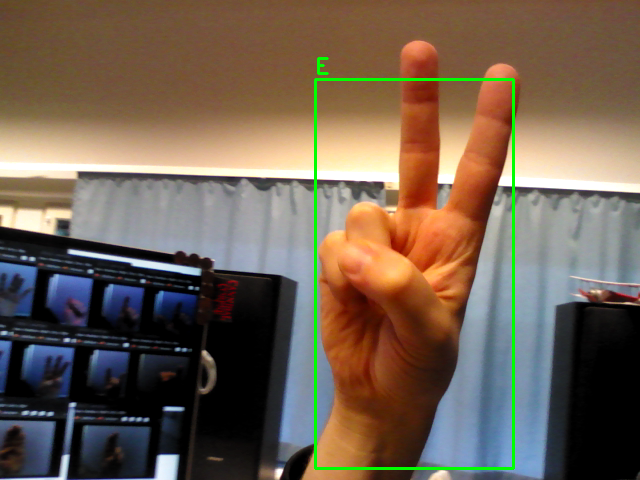

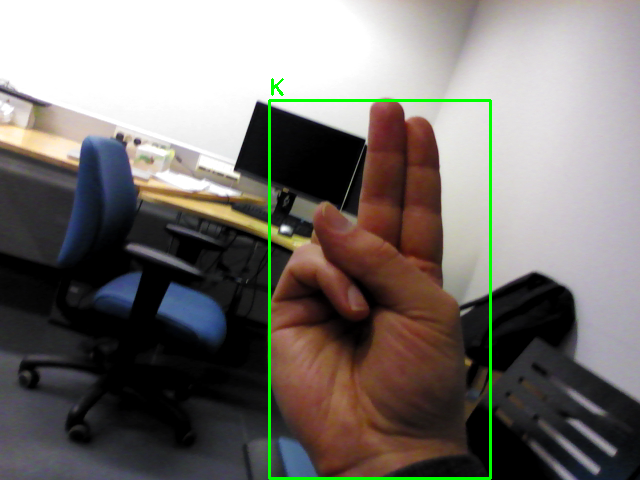

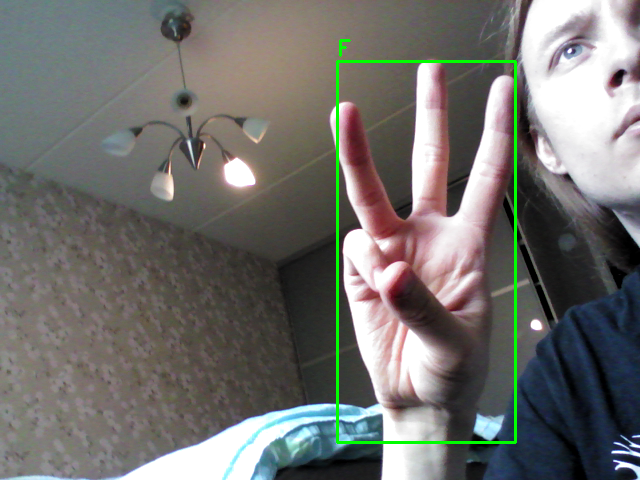

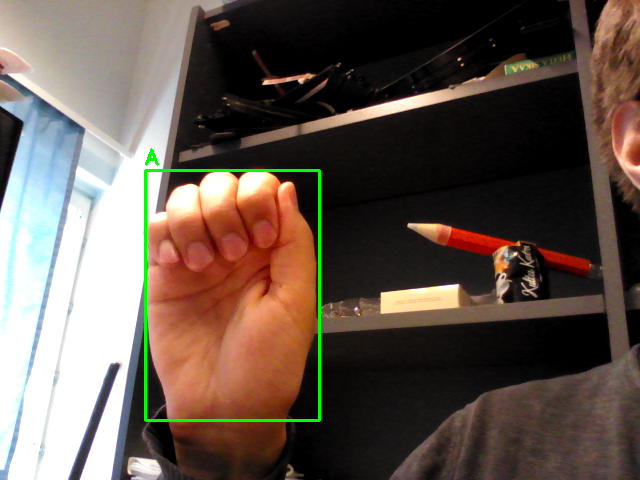

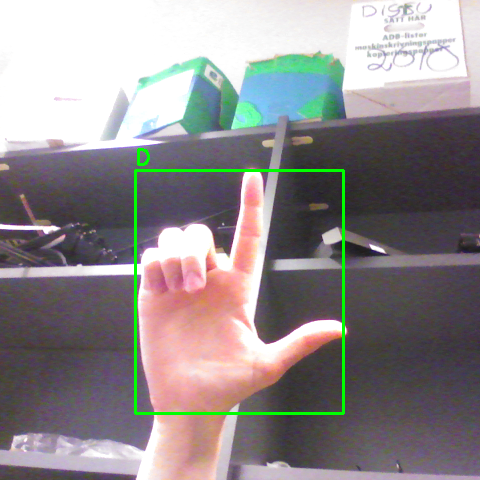

In [5]:
random.seed(0)

samples = []
img_dir = OUT_ROOT / "train" / "images"
lbl_dir = OUT_ROOT / "train" / "labels"
all_imgs = sorted([p for p in img_dir.iterdir() if p.suffix.lower() in IMG_EXTS])
samples = random.sample(all_imgs, k=min(5, len(all_imgs)))

for imgp in samples:
    im = cv2.imread(str(imgp))
    H, W = im.shape[:2]
    with open(lbl_dir / f"{imgp.stem}.txt", "r") as f:
        for ln in f:
            cid, cx, cy, w, h = map(float, ln.split())
            x1 = int((cx - w/2) * W)
            y1 = int((cy - h/2) * H)
            x2 = int((cx + w/2) * W)
            y2 = int((cy + h/2) * H)
            cv2.rectangle(im, (x1,y1), (x2,y2), (0,255,0), 2)
            cv2.putText(im, CLASSES[int(cid)], (x1, max(0,y1-6)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)
    display(Image.fromarray(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)))


In [6]:
import torch
print("Using GPU?", torch.cuda.is_available())
print("GPU count:", torch.cuda.device_count())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")


Using GPU? True
GPU count: 1
GPU name: NVIDIA GeForce RTX 3060 Ti


In [7]:
# 轻量快速版
model = YOLO("yolov8n.pt")  # 或 yolov8s.pt 稍大更准
results = model.train(
    data=str(yaml_path),
    imgsz=640,
    epochs=100,
    batch=32,         # 视显存调整
    device=0,         # 无GPU可改为 "cpu"
    workers=0,        # Windows/Notebook 推荐 0/1，避免多进程卡住
    mosaic=0,         # 让框更稳定
    degrees=10,
    flipud=False,
    save_period=10

)


Ultralytics 8.3.227  Python-3.11.14 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Ti, 8192MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=D:\Courses\Csc2503\proj\data_yolo_ouhands_nb\data.yaml, degrees=10, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=False, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=1

Test

In [8]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"  # 避免 VSCode/Jupyter 的 OpenMP 冲突
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"


In [16]:
from pathlib import Path
import torch, math
from ultralytics import YOLO

# 你的权重与 test 数据（之前已按我给的脚本生成过 test 的 YOLO 结构）
WEIGHTS = r"D:\Courses\Csc2503\proj\runs\detect\train\weights\best.pt"
YAML_TEST = r"D:\Courses\Csc2503\proj\data_yolo_ouhands_test\data_test.yaml"
TEST_IMG_DIR = Path(r"D:\Courses\Csc2503\proj\data_yolo_ouhands_test\test\images")
TEST_LBL_DIR = Path(r"D:\Courses\Csc2503\proj\data_yolo_ouhands_test\test\labels")

CLASSES = ['A','B','C','D','E','F','H','I','J','K']
NUM_CLASSES = len(CLASSES)
device = 0 if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: 0


In [18]:
import numpy as np

def read_yolo_label(label_path):
    """
    读取 YOLO 标签文件：cid cx cy w h(归一化)，返回 [(cid, x1,y1,x2,y2)]（像素还原需要传入图像宽高）
    这里先返回归一化，等读图片后再还原像素坐标。
    """
    if not label_path.exists():
        return []
    rows = []
    for ln in label_path.read_text().splitlines():
        ln = ln.strip()
        if not ln: 
            continue
        parts = ln.split()
        if len(parts) < 5:
            continue
        cid, cx, cy, w, h = map(float, parts[:5])
        rows.append((int(cid), cx, cy, w, h))
    return rows

def xywhn_to_xyxy(px, py, pw, ph, W, H):
    xc, yc = px*W, py*H
    ww, hh = pw*W, ph*H
    x1 = max(0, xc - ww/2); y1 = max(0, yc - hh/2)
    x2 = min(W-1, xc + ww/2); y2 = min(H-1, yc + hh/2)
    return x1, y1, x2, y2

def box_iou(a, b):
    # a: (N,4), b: (M,4) in xyxy
    N, M = a.shape[0], b.shape[0]
    iou = np.zeros((N, M), dtype=np.float32)
    for i in range(N):
        ax1, ay1, ax2, ay2 = a[i]
        aarea = max(0, ax2-ax1) * max(0, ay2-ay1)
        for j in range(M):
            bx1, by1, bx2, by2 = b[j]
            barea = max(0, bx2-bx1) * max(0, by2-by1)
            ix1, iy1 = max(ax1, bx1), max(ay1, by1)
            ix2, iy2 = min(ax2, bx2), min(ay2, by2)
            iw, ih = max(0, ix2-ix1), max(0, iy2-iy1)
            inter = iw * ih
            union = aarea + barea - inter if aarea + barea - inter > 0 else 1e-9
            iou[i, j] = inter / union
    return iou

def greedy_match(iou_mat, thr=0.5):
    """
    简单贪心：每次取当前全局最大 IoU ≥ thr 的 (gt, pred) 配对，直到没有可配对项。
    返回：pairs = [(gi, pj), ...]，以及未匹配的索引集合
    """
    iou = iou_mat.copy()
    pairs = []
    used_g, used_p = set(), set()
    while True:
        gi, pj = np.unravel_index(np.argmax(iou), iou.shape)
        if iou[gi, pj] < thr:
            break
        pairs.append((gi, pj))
        used_g.add(gi); used_p.add(pj)
        iou[gi, :] = -1.0
        iou[:, pj] = -1.0
    all_g = set(range(iou_mat.shape[0]))
    all_p = set(range(iou_mat.shape[1]))
    unmatched_g = list(all_g - used_g)
    unmatched_p = list(all_p - used_p)
    return pairs, unmatched_g, unmatched_p


In [19]:
from ultralytics.utils.plotting import Annotator
from PIL import Image
import cv2

model = YOLO(WEIGHTS)

# 统计：每类 TP/FP/FN（用于 Macro-F1）
TP = np.zeros(NUM_CLASSES, dtype=np.int64)
FP = np.zeros(NUM_CLASSES, dtype=np.int64)
FN = np.zeros(NUM_CLASSES, dtype=np.int64)

# 统计 Top-1（以“每个GT实例”为一次分类）：匹配到且类别正确记 1，否则 0
correct_per_gt = []

# 逐图预测（避免 DataLoader 多进程，Windows 更稳）
for img_path in sorted(TEST_IMG_DIR.iterdir()):
    if img_path.suffix.lower() not in {".png",".jpg",".jpeg",".bmp",".tif",".tiff"}:
        continue

    # 读取 GT
    lbl_path = TEST_LBL_DIR / f"{img_path.stem}.txt"
    gt = read_yolo_label(lbl_path)

    # 图片宽高
    im = cv2.imread(str(img_path))
    if im is None: 
        continue
    H, W = im.shape[:2]

    # 还原 GT 到像素坐标
    gt_boxes = []
    gt_cls = []
    for cid, cx, cy, w, h in gt:
        x1,y1,x2,y2 = xywhn_to_xyxy(cx, cy, w, h, W, H)
        gt_boxes.append([x1,y1,x2,y2])
        gt_cls.append(cid)
    gt_boxes = np.array(gt_boxes, dtype=np.float32)
    gt_cls = np.array(gt_cls, dtype=np.int32)

    # 预测（单图，关掉冗余）
    preds = model.predict(source=str(img_path), imgsz=640, conf=0.25, iou=0.6, device=device, stream=False, verbose=False)
    pred = preds[0]
    if pred.boxes is None or len(pred.boxes) == 0:
        # 全部 GT 记为 FN；Top-1 对应这些都算错
        for c in gt_cls:
            FN[c] += 1
            correct_per_gt.append(0)
        continue

    # 提取预测框与类别（像素坐标）
    pxyxy = pred.boxes.xyxy.cpu().numpy()
    pcls  = pred.boxes.cls.cpu().numpy().astype(int)

    if len(gt_boxes) == 0:
        # 没有 GT，本图全部预测记 FP
        for c in pcls:
            FP[c] += 1
        continue

    # IoU 匹配（gt vs pred）
    iou = box_iou(gt_boxes, pxyxy)
    pairs, unmatched_g, unmatched_p = greedy_match(iou, thr=0.5)

    # 处理配对
    for gi, pj in pairs:
        g_c = gt_cls[gi]
        p_c = pcls[pj]
        if g_c == p_c:
            TP[g_c] += 1
            correct_per_gt.append(1)   # 该GT实例分类正确
        else:
            FN[g_c] += 1
            FP[p_c] += 1
            correct_per_gt.append(0)   # 该GT实例分类错误

    # 未匹配的 GT → FN
    for gi in unmatched_g:
        g_c = gt_cls[gi]
        FN[g_c] += 1
        correct_per_gt.append(0)

    # 未匹配的预测 → FP
    for pj in unmatched_p:
        p_c = pcls[pj]
        FP[p_c] += 1

# === 指标计算 ===
# Top-1（以GT实例为单位）
top1 = float(np.mean(correct_per_gt)) if correct_per_gt else 0.0

# Macro-F1
f1_per_class = []
for k in range(NUM_CLASSES):
    tp, fp, fn = TP[k], FP[k], FN[k]
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    rec  = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1   = 2*prec*rec/(prec+rec) if (prec+rec) > 0 else 0.0
    f1_per_class.append(f1)
macro_f1 = float(np.mean(f1_per_class)) if f1_per_class else 0.0

print(f"Top-1: {top1:.4f}")
print(f"Macro-F1: {macro_f1:.4f}")


Top-1: 0.8860
Macro-F1: 0.8971


In [20]:
from thop import profile

model_core = model.model
dummy = torch.randn(1, 3, 640, 640)
if device != "cpu": dummy = dummy.cuda()

flops, params = profile(model_core, inputs=(dummy,), verbose=False)
params_m = params/1e6
flops_g  = flops/1e9
print(f"Params (M): {params_m:.3f}")
print(f"FLOPs (G): {flops_g:.2f}")


Params (M): 3.008
FLOPs (G): 4.05
